# Predicting Ski Resort Ratings

In [1]:
import pandas as pd
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', 200)
import numpy as np

## Load Data

In [2]:
df_resorts = pd.read_csv("data/resorts_data_for_ratings.csv", index_col=0)

In [3]:
# As an initial approach drop any columns that will not be part of training the model
# eg columns that can be inferred from other columns to reduce collinearity
df_resorts.drop(columns=["Name", "Max Elevation (m)", "Black Piste Percent" ], inplace=True)

In [4]:
# Set up the Star Rating as a classifier
# Values shall be rounded to the nearest integer
df_resorts.loc[:, ["Star Rating"]] = df_resorts[["Star Rating"]].apply(lambda x: np.around(x, decimals=0)).astype('str')

# Count the number of each rating
df_resorts["Star Rating"].value_counts()

2.0    2726
3.0    1053
4.0     309
5.0      18
Name: Star Rating, dtype: int64

In [5]:
# The number of 5 star rating's is very low, particularly once training, validation and testing is accounted for
# This could be managed by over-representing, but it will probably not be enough in this case. 
# Combine 4 and 5 star ratings instead
# Classifications: poor : 1,2, good: 3, excellent : 4,5

replacement = {"1.0":"poor", "2.0":"poor", "3.0":"good","4.0":"excellent","5.0":"excellent"}
for key in replacement:
    df_resorts["Star Rating"] = df_resorts["Star Rating"].str.replace(key, replacement[key], regex=False)
df_resorts

,Continent,Country,Star Rating,Elevation Change (m),Base Elevation (m),Total Piste Length (km),Blue Piste Percent,Red Piste Percent,Ski Lifts,Cost in Euros
Access Order,,,,,,,,,,
1,Europe,Austria,excellent,683,1630,100.0,61.0,35.0,26,49.0
2,Europe,Austria,excellent,1096,1004,27.3,47.0,46.0,8,49.5
3,Europe,Austria,excellent,1404,650,17.1,21.0,63.0,7,59.0
4,Europe,Austria,excellent,1120,740,42.0,43.0,52.0,14,50.0
5,Europe,Austria,excellent,1195,830,90.9,28.0,58.0,46,51.0
...,...,...,...,...,...,...,...,...,...,...
5870,Europe,Germany,low,40,420,1.0,70.0,30.0,1,NaN
5871,Europe,Germany,low,30,700,0.3,100.0,0.0,1,NaN
5874,Europe,Germany,low,40,740,0.3,100.0,0.0,1,8.0


In [6]:
df_resorts["Star Rating"].value_counts()

low          2726
good         1053
excellent     327
Name: Star Rating, dtype: int64

In [7]:
# Need to 1-hot encode categorical variables
df_resorts = pd.get_dummies(df_resorts, columns=["Continent", "Country"])

In [8]:
# Remove cases where the Cost in Euros of a ski pass is unavailable
# (In the future alterantive approaches shall be applied to manage the missing values)
df_resorts.dropna(subset=["Cost in Euros"], inplace=True)

In [9]:
# Save a copy of the data ready to be used by a classifier
df_resorts.to_csv("data/resort_data_classifier_ready.csv")

In [37]:
df_resorts

,Star Rating,Elevation Change (m),Base Elevation (m),Total Piste Length (km),Blue Piste Percent,Red Piste Percent,Ski Lifts,Cost in Euros,Continent_Africa,Continent_Asia,...,Country_South Korea,Country_Spain,Country_Sweden,Country_Switzerland,Country_Tajikistan,Country_Turkey,Country_USA,Country_Ukraine,Country_United Kingdom,Country_Uzbekistan
Access Order,,,,,,,,,,,,,,,,,,,,,
1,excellent,683,1630,100.0,61.0,35.0,26,49.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,excellent,1096,1004,27.3,47.0,46.0,8,49.5,0,0,...,0,0,0,0,0,0,0,0,0,0
3,excellent,1404,650,17.1,21.0,63.0,7,59.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,excellent,1120,740,42.0,43.0,52.0,14,50.0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,excellent,1195,830,90.9,28.0,58.0,46,51.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4890,low,30,764,0.2,100.0,0.0,1,5.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4892,low,40,765,0.2,100.0,0.0,1,14.0,0,0,...,0,0,0,1,0,0,0,0,0,0
4893,low,30,923,0.2,100.0,0.0,1,7.0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Classification

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [11]:
# Split out test set
df_train = df_resorts.drop(columns=["Star Rating"])
X_train, X_test, y_train, y_test = train_test_split(df_train, df_resorts["Star Rating"], test_size = 0.20)

In [12]:
# Use K-fold to split for cross validation
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=8)

In [13]:
# Start by trying to fit a Random Forest Classifier
# Use default hyperparameters to start with
rcf = RandomForestClassifier()

In [14]:
# Store validation scores
val_score = 0

for train_index, val_index in skf.split(X_train, y_train):
    rcf.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    
    val_score += rcf.score(X_train.iloc[val_index], y_train.iloc[val_index])
    
print(val_score / 8)

0.8973809523809523


In [15]:
# Check the results for any threshold issues
from sklearn.metrics import plot_confusion_matrix

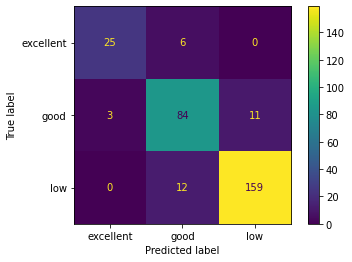

In [16]:
plot_confusion_matrix(rcf, X_train.iloc[val_index], y_train.iloc[val_index])

The confusion matrix suggests there is no big issue in the results with no extreme cases, i.e. a low resort being predicted as excellent. 
Later on during the threshold adjustments we may want to reduce the instance of false "improvements",i.e. predictions of good for low, and excellent for good resorts.

## Hyperparameter Testing

The Random Forest Classifier includes the following options:
* n_estimators, default is 100, represents the number of trees in the forest (classifiers in the ensemble?)
* max_depth, default is none, limit to number of splits (limiting this should reduce overfitting)
* min_samples_split or min_samples_leaf, default is 2 and 1 respectively, increasing values should reduce overfitting and limit the impact of the country feature
* max_features, default is sqrt, limits the features available. log2 or None are alternative options
* class_weight, default is none, "balanced" can be used to adjust weights based on frequency, option appears to be related to thresholds
* ccp_alpha, default is 0.0, essentially a regularisation term, 0.05 is probably a good max value

In [17]:
# Create hyperparameter grid

n_est = [50, 100, 150]
max_depth = [None, 5, 10]
min_samples = [2, 4, 6]
max_features = ["sqrt", "log2", None]
class_weight = [None, "balanced"]
ccp_alpha = [i * 0.025 for i in range(3)]  # Should give: 0.00, 0.025, 0.05

# Form hyperparameters into a list of dictionaries
hyper = [{"n_estimators":n, "max_depth":md, "min_samples_split":ms, "max_features":mf, "class_weight":cw, "ccp_alpha":a} 
         for n in n_est for md in max_depth for ms in min_samples for mf in max_features for cw in class_weight for a in ccp_alpha]

### **Warning!** Long running time

In [33]:
# Store the values
best_hyper_parameters, best_score, val_score = None, 0.0, 0.0

for param in hyper:
    rcf = RandomForestClassifier(**param)
    for train_index, val_index in skf.split(X_train, y_train):
        rcf.fit(X_train.iloc[train_index], y_train.iloc[train_index])
        val_score += rcf.score(X_train.iloc[val_index], y_train.iloc[val_index])
    val_score = val_score / 8
    
    if val_score > best_score:
        second_best_score = best_score
        second_best_parameters = best_hyper_parameters
        best_score = val_score
        best_hyper_parameters = param
    # Reset score
    val_score = 0.0
        
print(*best_hyper_parameters.items())
print("Score is ", best_score)  
print("Second best hyperparameters =",*second_best_parameters.items())
print("Score is ", second_best_score)     

('n_estimators', 150) ('max_depth', None) ('min_samples_split', 2) ('max_features', 'log2') ('class_weight', None) ('ccp_alpha', 0.0)
Score is  0.9090130121816168
Second best hyperparameters = ('n_estimators', 100) ('max_depth', None) ('min_samples_split', 2) ('max_features', 'log2') ('class_weight', 'balanced') ('ccp_alpha', 0.0)
Score is  0.9081824473975637


## Evaluation

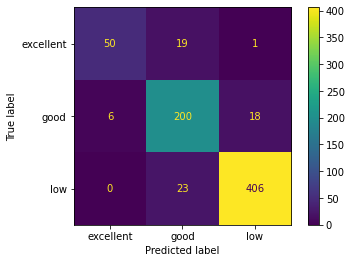

In [18]:
# Lets do some model evaluation
rcf = RandomForestClassifier(**best_hyper_parameters)

# Uncomment this to avoid running the hyperparameter training
#rcf = RandomForestClassifier(n_estimators=150, max_depth=None, min_samples_split=2, max_features='log2', class_weight=None, ccp_alpha=0.0)

# Need to limit fit to a subset of the data otherwise evaluation may be faulty
X_train_eval, X_val, y_train_eval, y_val = train_test_split(X_train, y_train, test_size = 0.30, random_state=8)

rcf.fit(X_train_eval, y_train_eval)

# Get a new confusion matrix based on the validation data
plot_confusion_matrix(rcf, X_val, y_val)

Model performance is generally good, but there are 31 cases where the class is over-estimated, i.e. "low" identified as "good", "good" identified as "excellent".

In [19]:
# Lets look at the 5 most important features as a sanity check
df_importances = pd.DataFrame({"features":X_train.columns, 'importances': np.round(rcf.feature_importances_, 3)*100})
df_importances.sort_values('importances', axis=0, ascending=False)[:5]

,features,importances
2,Total Piste Length (km),23.5
0,Elevation Change (m),16.4
6,Cost in Euros,14.0
5,Ski Lifts,13.2
3,Blue Piste Percent,6.9


### Calibration

In [20]:
# If our customers are to be informed on the impact of planned changes then they must have a high-degree of confidence that the effects are not over-estimated. 
# Before trying to resolve this manually, let's use probability calibration to see if we can improve.

from sklearn.calibration import CalibratedClassifierCV

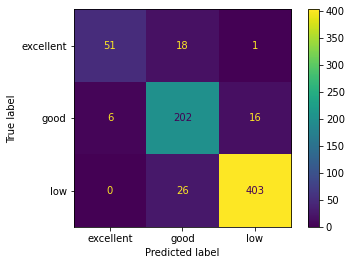

In [21]:
# Perform calibration of the pre-fit random for classifier
cal_rcf = CalibratedClassifierCV(rcf, method="sigmoid", cv="prefit")

# Compare performance by assessing the new confusion matrix
# For binary cases a brier_score_loss could be used, but is inappropriate for 3 or more classes.
plot_confusion_matrix(cal_rcf.fit(X_train_eval, y_train_eval), X_val, y_val)

### ROC AUC

Not a successful approach. Some metrics have deteriorated, while others improved. A more manual approach is required to achieve the stated aims.

In [22]:
# Use the ROC curve (True Positive Rate over False Positive Rate) to assess the currrent implimentation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [23]:
# Use multi-class equals one vs one because we are interested in adjacent class relationships
roc_auc_score(y_val, rcf.predict_proba(X_val), multi_class="ovo")

0.9721312417740989

### Probabilities

That's a near ideal score, and we are not aiming to improve it.
We want to specifically impalance the predictions towards the lower end.
Specifically, if we consider the 'excellent'/'good' split seperately as 'positive/negative'. We want to increase the Precision, i.e. the ratio of 'True Positives' to 'Positive Predictions'.
We also want to do the equivalent for the 'good'/'low' split.

Let's review the current probabilities and explore the results

In [24]:
# Generate a DataFrame to play with predicted probabilities for each label, the correct label, and predicted labels
df_explore = pd.DataFrame({'prob_excellent': rcf.predict_proba(X_train)[:, 0], 'prob_good': rcf.predict_proba(X_train)[:, 1], 'prob_low': rcf.predict_proba(X_train)[:, 2],
                           'labels': y_train, 'pred_labels': rcf.predict(X_train)})

In [25]:
# Look at the difference where an incorrect prediction is made and when a correct one is made
df_explore[(df_explore["pred_labels"] == 'excellent') & (df_explore["labels"] != df_explore["pred_labels"])].sort_values('prob_excellent', axis=0)

,prob_excellent,prob_good,prob_low,labels,pred_labels
Access Order,,,,,
971,0.440000,0.326667,0.233333,good,excellent
353,0.526667,0.466667,0.006667,good,excellent
338,0.533333,0.466667,0.000000,good,excellent
482,0.566667,0.360000,0.073333,good,excellent
551,0.626667,0.340000,0.033333,good,excellent
421,0.700000,0.266667,0.033333,good,excellent


In [26]:
df_explore[(df_explore["pred_labels"] == 'excellent') & (df_explore["labels"] == df_explore["pred_labels"])].sort_values('prob_excellent', axis=0)

,prob_excellent,prob_good,prob_low,labels,pred_labels
Access Order,,,,,
135,0.493333,0.473333,0.033333,excellent,excellent
219,0.513333,0.486667,0.000000,excellent,excellent
136,0.520000,0.480000,0.000000,excellent,excellent
22,0.520000,0.466667,0.013333,excellent,excellent
240,0.526667,0.460000,0.013333,excellent,excellent
...,...,...,...,...,...
61,1.000000,0.000000,0.000000,excellent,excellent
68,1.000000,0.000000,0.000000,excellent,excellent
60,1.000000,0.000000,0.000000,excellent,excellent


### Precision

In [27]:
# Looking at the data there is no obvious way to improve the model precision while maintaining accuracy

# Create a function to predict labels with higher precision
def improve_precision(label_string:list, classifier, data, true_labels, min_accuracy=0.85):
    
    precision = precision_score(true_labels, classifier.predict(data), average=None)
    accuracy = accuracy_score(true_labels, classifier.predict(data))
    
    print(f"Starting accuracy is {round(accuracy, 2)}")
    print(f"Initial precision of excellent resorts is {round(precision[0], 2)}\nInitial precision of good resorts is {round(precision[1], 2)}")
    
    # Define initial adjustment
    modifier = 0.01
    
    pred_labels = np.argmax(classifier.predict_proba(data), axis=1)
    probabilities = classifier.predict_proba(data)
      
    while (accuracy > min_accuracy) | (precision[0] < 0.99):
        new_labels = []
        for i in range(len(true_labels)):
            if pred_labels[i] == 0:
                diff = probabilities[i,0] - probabilities[i,1]
                
                if diff < modifier:
                    new_labels.append(label_string[1])
                else:
                    new_labels.append(label_string[0])
                    
            elif pred_labels[i] == 1:
                diff = probabilities[i,1] - probabilities[i,2]
                
                if diff < modifier:
                    new_labels.append(label_string[2])
                else:
                    new_labels.append(label_string[1])
            
            else:
                new_labels.append(label_string[2])
                
        accuracy = accuracy_score(true_labels, new_labels)
        precision = precision_score(true_labels, new_labels, average=None)
        modifier += 0.01
    
    print(f"Accuracy is {round(accuracy, 2)}")
    print(f"Precision of excellent resorts is {round(precision[0], 2)}\nPrecision of good resorts is {round(precision[1], 2)}")
    return new_labels
        
# Note: High accuracy to begin with as it is trained on the data it predicts
y_train_pred = improve_precision(['excellent', 'good', 'low'], rcf, X_train, y_train)

Starting accuracy is 0.97
Initial precision of excellent resorts is 0.97
Initial precision of good resorts is 0.95
Accuracy is 0.85
Precision of excellent resorts is 1.0
Precision of good resorts is 0.84


In [28]:
# Need a different approach for confusion matrix because of the post-processing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

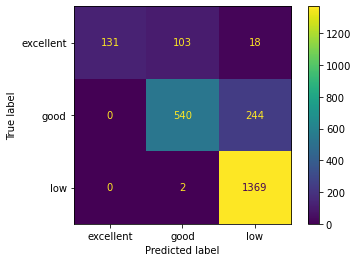

In [29]:
cm = confusion_matrix(y_train, y_train_pred)
cm_plot = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['excellent', 'good', 'low'])
cm_plot.plot()

### F-score

By focusing on precision, the accuracy of the estimation has fallen along with the likelihood of a resort being identified as excellent.
This could skew the results too far, failing to capture the impact of features and only rewarding substantial changes. A more 'forgiving' approach should be used.
The F-score considers both the precision (True Positives over Total Positive predictions) and the Recall (True Positives over Total Positives).
In the sklearn implimentation a factor beta is also included that can be used to modify the balance between the two. 

In [30]:
from sklearn.metrics import precision_recall_fscore_support

In [31]:
# Let's check the initial fit to begin with
# The "micro" option calculates the results globally, by considering all True Positive, True Negatives etc..
precision_recall_fscore_support(y_val, rcf.predict(X_val), beta=1.0, average="micro")

(0.9073305670816044, 0.9073305670816044, 0.9073305670816044, None)

F-score appears to be a surrogate for accuracy.
The lack of a threshold in class selection that is inherent in the Random Forest model means there does not appear to be much room for improvement without changing classifier.

## Test

In [32]:
# Check the scores
test_precision, test_recall, test_fscore, _ = precision_recall_fscore_support(y_test, rcf.predict(X_test), beta=1.0, average="macro")
print(f"The model fits the data with:\nPrecision = {round(test_precision, 3)}\nRecall = {round(test_recall, 3)}\nF-score = {round(test_fscore, 3)}")

The model fits the data with:
Precision = 0.915
Recall = 0.865
F-score = 0.883


In [33]:
# Now apply the precision adjustment to our test data
y_test_pred = improve_precision(['excellent', 'good', 'low'], rcf, X_test, y_test)

Starting accuracy is 0.92
Initial precision of excellent resorts is 0.98
Initial precision of good resorts is 0.8
Accuracy is 0.85
Precision of excellent resorts is 1.0
Precision of good resorts is 0.76


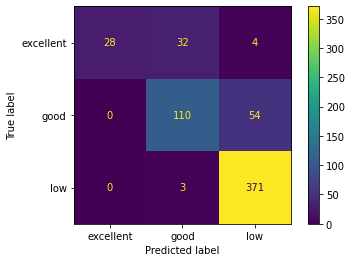

In [34]:
# Confusion Matrix of the final model
# No false positives in the excellent category
# Very limited, 2/346, false positives in the good category
# Conversely, a lot of miscategorisation. It may over-estimate the investment required to achieve 'excellent' status
# More than half the excellent predictions have ended up in other categories

cm = confusion_matrix(y_test, y_test_pred)
cm_plot = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['excellent', 'good', 'low'])
cm_plot.plot()

## Deploy

In [ ]:
# Save model ready for use

In [35]:
import pickle

pickle.dump(rcf, open("random_forest_model.pkl", "wb"))